<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


# Introduction to Hand Image Classification
This notebook presents a machine learning project focused on classifying hand images. Our objective is to develop a model capable of distinguishing between real hand images, and those generated by Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs). The notebook covers the entire workflow including data preprocessing, model training, and evaluation. Insights derived from this project aim to contribute to the understanding of how different deep learning techniques can be applied to image classification tasks.

## Data preparation

In [1]:
# Standard library imports
import csv
import os
import re
import sys
sys.path.append('../src')
# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
import torch.nn.functional as F  # PyTorch Functional
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from livelossplot import PlotLosses
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Local imports
from utils import set_device, set_seed, plot_confusion_matrix
from dataset import custom_collate_fn, HandDataset
from train_cnn import train, validate




device = set_device("cuda")
set_seed(42)

No GPU available! Running on CPU


True

In [2]:
batch_size = 64

# Define transformations

# For training
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.RandomRotation(degrees=10), # Randomly rotate images by 10 degrees to help with generalization
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally to help with generalization
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# For testing
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

directories = ['../data/real_hands', '../data/VAE_hands', '../data/GAN_hands']
image_paths = []
labels = []

# Assign labels to images: 0 for real hands, 1 for VAE hands, 2 for GAN hands
for i, directory in enumerate(directories):
    if not os.path.isdir(directory):
        raise FileNotFoundError(f"Directory not found: {directory}")
    images = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith('.jpeg')]
    image_paths.extend(images)
    labels.extend([i] * len(images))  # Label assignment

# Split the paths and labels into train, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create instances of the dataset
full_dataset = HandDataset(image_paths, labels, transform=train_transform)  # For final training
train_dataset = HandDataset(train_paths, train_labels, transform=train_transform)
test_dataset = HandDataset(test_paths, test_labels, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

### Batch size:
This time around I added far more hyperparamters to be tuned such as dropout rate etc so in the interest of making sure I have enough time I created a short test of 20 epochs in this notebook to test parameters that i wont use a grid search for. Batch size was one of them and I found that using size 64 was better than 32 and 128

In [3]:
# size of whole dataset adding train, test, val if values are not none
def length_of_dataset_without_none(dataset):
    return len([item for item in dataset if item is not None])

print(f"Number of training samples: {length_of_dataset_without_none(train_dataset) + length_of_dataset_without_none(test_dataset)}")

Number of training samples: 1448


In [4]:
# Check for empty batches in the train_loader
# This is important to ensure that all batches contain data and no batch is empty due to filtering in custom_collate_fn

none_indices = []
for i, (images, labels) in enumerate(train_loader):
    if images.nelement() == 0:  # Check if the batch is empty
        none_indices.append(i)

print(f"Indices with empty batches: {none_indices}")

Indices with empty batches: []


Empty indices which is good. Empty batchs could occur due to the `custom_collate` function and this needed to be dealt with.

Batch size: 64
Number of batches: 19
Total number of images: 1158
Image shape: torch.Size([1, 32, 32])


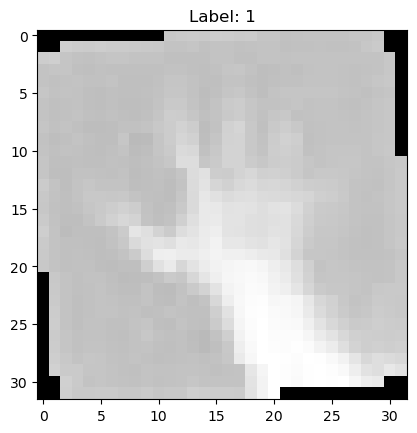

Number of pixels in each image: 1024
Pixel value range: max, 1.0 min, -1.0


In [5]:
# DataLoader Overview
print("Batch size:", train_loader.batch_size)
print("Number of batches:", len(train_loader))
print("Total number of images:", len(train_loader.dataset))

# Fetching the First Batch
images, labels = next(iter(train_loader))

# Inspecting the First Image
print("Image shape:", images[0].shape)  # Shape: [batch_size, n_channels, height, width]
plt.imshow(images[0].squeeze(), cmap='gray')  # Display the image (assuming grayscale)
plt.title(f'Label: {labels[0].item()}')
plt.show()

# Image Details
print("Number of pixels in each image:", images[0].shape[1] * images[0].shape[2])
print("Pixel value range: max,", images.max().item(), "min,", images.min().item())

## Network design and implementation

During my iterative process where i wanted to improve the architecture of the model before any hyperparameter training I notice some odd trends when training for 25 epochs. The test loss and accuracy are fluctuating across epochs. While the training loss generally decreases (indicating learning), the test loss does not consistently decrease. <br><br>This can suggest a few things, such as the model might be starting to overfit, or it may be sensitive to the learning rate or other hyperparameters. Too combat this I will be adding dropout rates and possibly reducing learning rates(will explore more during hyperparameter tuning).

1. First trying batch normalisation  and dropouts:
The addition of dropout and batch normalization layers did not lead to the expected performance improvements. This suggests the need for further adjustments, possibly involving tuning hyperparameters like the learning rate and dropout rate, or reconsidering the model's complexity.

2. Reducing the models complexity to 2 layers:
I kept the batch norm and the dropout and reduced my NN to two conv layers instead of the 6 I originally had.This has significantly improved the loss graph and no longer seems to overfit in such a drastic way.

2 conv layers, 2 fc layers, 3 dropout layer, 2 batchnorm layer, 2 maxpool layer seems to be the best one so far however the validation loss seems very volatile.

3. Added a Global Average Pooling (GAP) layer after the convolutional layers.This is supposed help in reducing the number of parameters compared to a fully connected layer and aids in combating overfitting.

4. Lots of GANs generated images were being classed as Real and this means that the very small differences between the images needed to be observed so I experimented with increasing the depth by adding a third and fourth convolutional layer.This seems to give me the most stable loss plot and best confusion matrix.

Also parameters such as dropout will be explored in the ```Hyperparameter_Tuning.ipynb``` notebook.

**Note**: The `CustomCNN` model used in this notebook has been defined in a separate file `model.py` located in the `src` directory for modularity and reusability. This allows the model to be easily imported into other scripts or notebooks. For the purpose of demonstration and ease of understanding, the model architecture is also included below.

In [6]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # New convolutional layer
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 3)
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        
        x = self.gap(x)
        x = x.view(-1, 128)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## Model Training and Validation

In this section, we perform the model training over several epochs. We use a custom training loop that includes both training and validation phases. During training, we optimize the model parameters, and in the validation phase, we assess the model's performance on unseen data. We also utilize `livelossplot` for real-time visualization of the training and validation losses, and a learning rate scheduler to adjust the learning rate based on training loss.

In [7]:
# Optimal hyperparameters found from grid search
lr = 0.0001
weight_decay = 1e-7
patience = 6

In [8]:
model = CustomCNN()
device = torch.device('cpu') # function is not working locally so using this instead
model = model.to(device) # Move model to GPU if available
optimizer = torch.optim.Adam(model.parameters(), lr=lr , weight_decay=weight_decay) # Create the optimizer
criterion = nn.CrossEntropyLoss() # Specify the loss layer
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=0.6, min_lr=1e-7, verbose=True) # Reduce learning rate on plateau

In [9]:
num_epochs = 250 # Number of epochs to train for (if early stopping is not triggered)

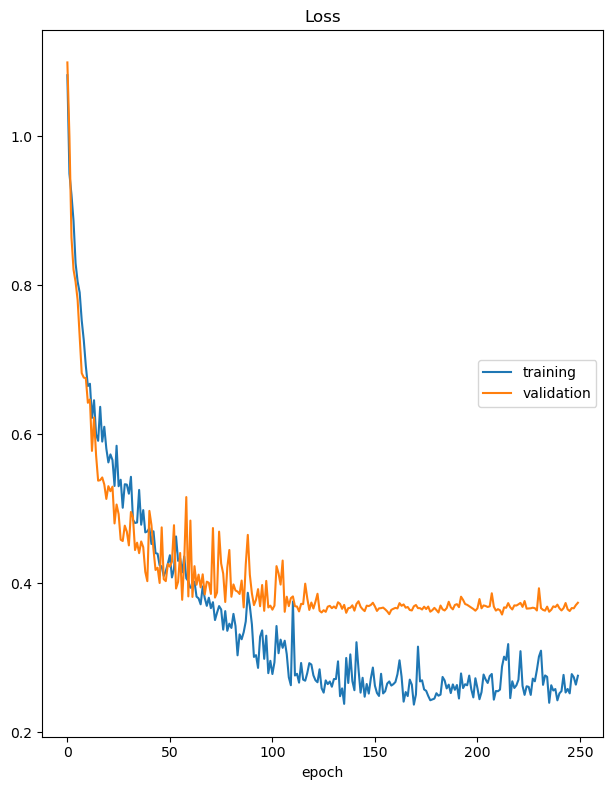

Loss
	training         	 (min:    0.237, max:    1.082, cur:    0.276)
	validation       	 (min:    0.358, max:    1.099, cur:    0.374)
Accuracy: 86.90%


In [10]:
# Initialize the plot
liveloss = PlotLosses()
for epoch in range(1, num_epochs + 1):
    avg_train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    avg_test_loss, accuracy = validate(model, device, test_loader, criterion)
    
    # Update the liveloss plot
    liveloss.update({
        'loss': avg_train_loss,
        'val_loss': avg_test_loss,
    })

    # Pass the correct variable to the scheduler
    scheduler.step(avg_train_loss)
    liveloss.send()  # Draw the updated figures
print(f'Accuracy: {accuracy:.2f}%')


Training the final model for around 100 epochs seems best as the loss begins to plateau and the accuracy is high.

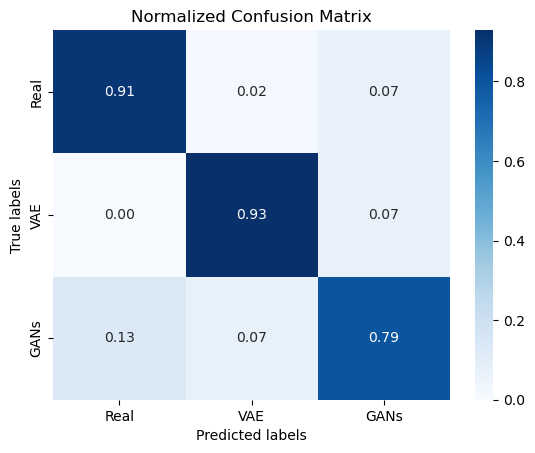

In [11]:
# lets plot the confusion matrix 
plot_confusion_matrix(model, device, test_loader)

## Training on the Entire Dataset

After extensive validation and testing with a separate training and test set, I am now training the model on the entire dataset. This approach is chosen to maximize the learning from all available data, as the model will be used for predicting labels on new, unseen data. It is important to note that this step is taken only after ensuring the model's generalizability and finalizing the architecture and hyperparameters.

In [12]:

# Initialize the model for the entire dataset
final_model = CustomCNN().to(device)  # Customize your model initialization as needed

# Define the optimizer
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, weight_decay=weight_decay)

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 100 # Set the number of epochs as per your requirement
for epoch in range(1, num_epochs + 1):
    train_loss = train(final_model, device, full_loader, optimizer, criterion, epoch)
    # Since there's no validation set, we only track the training loss


Epoch: 01, Train Loss: 1.0646
Epoch: 02, Train Loss: 0.9375
Epoch: 03, Train Loss: 0.8860
Epoch: 04, Train Loss: 0.8270
Epoch: 05, Train Loss: 0.7701
Epoch: 06, Train Loss: 0.7327
Epoch: 07, Train Loss: 0.6929
Epoch: 08, Train Loss: 0.6761
Epoch: 09, Train Loss: 0.6517
Epoch: 10, Train Loss: 0.6233
Epoch: 11, Train Loss: 0.6047
Epoch: 12, Train Loss: 0.5906
Epoch: 13, Train Loss: 0.5653
Epoch: 14, Train Loss: 0.5634
Epoch: 15, Train Loss: 0.5342
Epoch: 16, Train Loss: 0.5374
Epoch: 17, Train Loss: 0.5279
Epoch: 18, Train Loss: 0.5328
Epoch: 19, Train Loss: 0.5143
Epoch: 20, Train Loss: 0.4920
Epoch: 21, Train Loss: 0.5025
Epoch: 22, Train Loss: 0.4850
Epoch: 23, Train Loss: 0.4900
Epoch: 24, Train Loss: 0.4777
Epoch: 25, Train Loss: 0.4726
Epoch: 26, Train Loss: 0.4751
Epoch: 27, Train Loss: 0.4437
Epoch: 28, Train Loss: 0.4476
Epoch: 29, Train Loss: 0.4450
Epoch: 30, Train Loss: 0.4518
Epoch: 31, Train Loss: 0.4300
Epoch: 32, Train Loss: 0.4293
Epoch: 33, Train Loss: 0.4074
Epoch: 34,

In [13]:
# Save the trained model
model_path = '../model/final_cnn_model.pth'
torch.save({
    'epoch': num_epochs,
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss,
}, model_path)

print(f'Model saved to {model_path}')


Model saved to ../model/final_cnn_model.pth


## Making Predictions on Unseen Data

In this section, the trained model is utilized to predict labels for a new set of hand images. These predictions are essential for understanding the model's performance on unseen data. The results will be sorted and saved in a CSV file for further analysis or use.

In [14]:
import torch
# For unlabeled test data
test_dataset = HandDataset(image_paths_or_dir="../data/test_hands", labels=None, transform=test_transform)
test_hand_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)


final_model.eval()  # Set the model to evaluation mode
results = []

for batch in test_hand_loader:
    images, img_names = batch
    if images is None or len(images) == 0:  # Check for an empty batch or tensor
        continue  # Skip this loop iteration if the batch is empty

    images = images.to('cpu')  # Move images to the CPU

    # Make predictions
    with torch.no_grad():
        outputs = final_model(images)
        _, preds = torch.max(outputs, 1)
        results.extend(zip(img_names, preds.tolist()))

# Regex sorts by extracting numbers from the image name and sorting numerically
sorted_results = sorted(results, key=lambda x: int(re.search(r'\d+', x[0]).group())) 

# Write the results to a CSV file
csv_file = '../classified_hands.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    for img_name, prediction in sorted_results:
        writer.writerow([img_name, prediction])

print(f'Classification completed. Results saved to {csv_file}.')

Classification completed. Results saved to ../classified_hands.csv.
